# Setting Up

### Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [2]:
dataset = reader.load_dataset(constants.MASS_SS_NAME, params={pkeys.FS: 200})
fs = dataset.fs

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [22]:
# characterization
all_n2_pages = dataset.get_pages(pages_subset=constants.N2_RECORD)
for_mean = []
for single_sub in all_n2_pages:
    print(single_sub.size)
    for_mean.append(single_sub.size*20 / 60)
    # for_mean.append(single_sub.size)
print(np.mean(for_mean), np.std(for_mean))

t_stamps_e1 = dataset.get_stamps(which_expert=1, pages_subset=constants.N2_RECORD)
# t_stamps_e2 = dataset.get_stamps(which_expert=2, pages_subset=constants.N2_RECORD)
for_mean_e1 = []
# for_mean_e2 = []
# for single_sub_e1, single_sub_e2 in zip(t_stamps_e1, t_stamps_e2):
for single_sub_e1 in t_stamps_e1:
    n_e1 = single_sub_e1.shape[0]
    # n_e2 = single_sub_e2.shape[0]
    # n_e1 = np.sum((single_sub_e1[:, 1] - single_sub_e1[:, 0]) / dataset.fs) / 60
    #n_e2 = np.sum((single_sub_e2[:, 1] - single_sub_e2[:, 0]) / dataset.fs) / 60
    print(n_e1)
    # print(n_e2)
    for_mean_e1.append(n_e1)
    # for_mean_e2.append(n_e2)
print('e1', np.mean(for_mean_e1), np.std(for_mean_e1))
# print('e2', np.mean(for_mean_e2), np.std(for_mean_e2))

745
911
496
633
676
694
739
696
638
689
818
730
797
735
804
240.0222222222222 30.91193384958288
406
633
507
395
670
423
876
999
436
857
269
568
590
812
186
e1 575.1333333333333 226.81853735726472


In [15]:
durations = 


(314,)

In [10]:
all_means = []
for subject_id in dataset.get_ids():
    stamps_e1 = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    stamps_e2 = dataset.get_subject_stamps(subject_id, which_expert=2, pages_subset=constants.N2_RECORD)
    iou_array, _ = metrics.matching(stamps_e1, stamps_e2)
    iou_array = iou_array[iou_array>0]
    all_means.append(iou_array.mean())
print(np.mean(all_means))

0.6075975453470444


### Available prediction checkpoints

In [3]:
filter_dates = [20191227, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20191227_bsf_10runs_e1_n2_train_mass_ss/v19
    20191227_bsf_10runs_e1_n2_train_mass_ss/v11
    20191227_bsf_10runs_e2_n2_train_mass_ss/v19
    20191227_bsf_10runs_e2_n2_train_mass_ss/v11
    20191227_bsf_10runs_e1_n2_train_mass_kc/v19
    20191227_bsf_10runs_e1_n2_train_mass_kc/v11
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_128
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_128
    20200409_attention_grid_n2_train_mass_kc/att01_d_512_h_8_fc_0
    20200409_attention_grid_n2_train_mass_kc/att01_d_512_h_8_fc_128
    20200409_attention_grid_n2_train_mass_

### Load database and predictions

In [8]:
# Specify what to load
# ckpt_folder = '20191227_bsf_10runs_e1_n2_train_mass_ss/v11'
ckpt_folder = '20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5'
dataset_name = constants.MASS_SS_NAME
which_expert = 1
task_mode = constants.N2_RECORD
ckpt_fs = 200
seed_id_list = [i for i in range(10)]
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]

# Load data
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: ckpt_fs})
fs = dataset.fs
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = reader.read_prediction_with_seeds(
    ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
optimal_thr_list = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder]
print('Optimal thr:', optimal_thr_list)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5/seed3
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5/seed4
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_m

### Global specs

In [9]:
model_label = 'Proposed Model'

iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper())
pr_curve_thr = misc.custom_linspace(0.1, 0.9, 0.02)

### Load baselines

In [60]:
baselines_to_show_dict = {
    constants.SPINDLE: ['2019_chambon', '2019_lacourse'],
    constants.KCOMPLEX: ['2019_chambon', '2017_lajnef']
}
baselines_names_to_show = baselines_to_show_dict[dataset.event_name]
baselines_data_dict = reader.load_baselines(
    baselines_names_to_show, ids_dict[constants.TEST_SUBSET], dataset_name, which_expert)
bs_keys = list(baselines_data_dict[baselines_names_to_show[0]].keys())
print('\nAvailable data:')
pprint(bs_keys)

2019_chambon found.  0  1  2  3  4  5  6  7  8  9 Loaded.
2019_lacourse found.  0  1  2  3  4  5  6  7  8  9 Loaded.

Available data:
['f1_vs_iou',
 'recall_vs_iou',
 'precision_vs_iou',
 'iou_hist_bins',
 'iou_curve_axis',
 'iou_hist_values',
 'mean_iou',
 'mean_af1']


### Load expert performance

In [61]:
expert_data_dict = reader.load_ss_expert_performance()
exp_keys = list(expert_data_dict.keys())
print('\nAvailable data:')
pprint(exp_keys)


Available data:
['iou_curve_axis', 'f1_vs_iou_mean', 'f1_vs_iou_std', 'recall', 'precision']


# Test Performance Comparison with Baselines

### Performance vs IoU

In [47]:
model_data_dict = performer.performance_vs_iou_with_seeds(
    dataset,
    predictions_dict,
    optimal_thr_list,
    iou_curve_axis,
    iou_hist_bins,
    task_mode,
    which_expert
)

# Mean performance
mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
iou_curve_axis_short = misc.custom_linspace(0.1, 0.9, 0.1)
iou_curve_axis_short_idx = [
    misc.closest_index(this_value, iou_curve_axis) 
    for this_value in iou_curve_axis_short
]
mean_f1_vs_iou_short = mean_f1_vs_iou[iou_curve_axis_short_idx]
std_f1_vs_iou_short = std_f1_vs_iou[iou_curve_axis_short_idx]
print('IoU   Mean    Std')
for k in range(len(iou_curve_axis_short)):
    print('%1.2f  %1.4f  %1.4f' % (iou_curve_axis_short[k], mean_f1_vs_iou_short[k], std_f1_vs_iou_short[k]))
print('Test AF1: %1.4f +- %1.4f' % (
    model_data_dict[constants.MEAN_AF1].mean(), model_data_dict[constants.MEAN_AF1].std()
))
print('Test AF1 per seed:', model_data_dict[constants.MEAN_AF1])
print('Test Mean IoU at TP: %1.4f +- %1.4f' % (
    model_data_dict[constants.MEAN_IOU].mean(), model_data_dict[constants.MEAN_IOU].std()
))

Creating cache that does not exists
IoU   Mean    Std
0.10  0.8250  0.0041
0.20  0.8233  0.0042
0.30  0.8228  0.0040
0.40  0.8226  0.0040
0.50  0.8213  0.0042
0.60  0.8162  0.0042
0.70  0.7978  0.0051
0.80  0.7491  0.0061
0.90  0.5684  0.0047
Test AF1: 0.7474 +- 0.0035
Test AF1 per seed: [0.75178031 0.74694269 0.74855184 0.74365489 0.74600589 0.75280269
 0.75205888 0.74546493 0.74319069 0.74379707]
Test Mean IoU at TP: 0.9044 +- 0.0018


Database: mass_ss, Expert: 1
IoU to show: 0.2
F1 80.85/0.36, Recall 81.34/1.55, Precision 81.24/1.23, AF1 68.54/0.35, IoU 84.85/0.19 for Proposed Model
F1 78.36/0.77, Recall 78.32/2.03, Precision 80.00/1.92, AF1 59.53/1.03, IoU 75.95/0.76 for Chambon et al. 2019
F1 71.41/0.31, Recall 75.29/0.44, Precision 69.32/0.77, AF1 54.68/0.33, IoU 76.43/0.11 for Lacourse et al. 2019


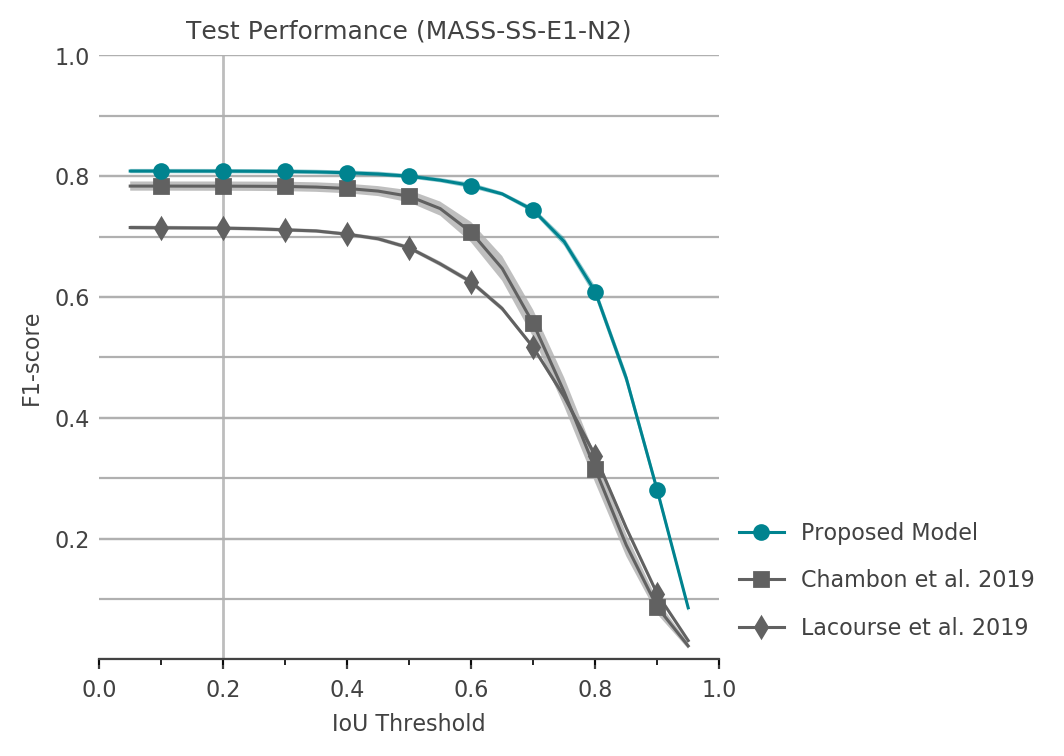

In [9]:
# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
compare_expert = False
compare_baselines = True
show_seed_std = True
alpha_seed_std = 0.4
alpha_expert = 0.5
iou_thr_to_show = 0.2
figsize = (4, 4)
title = 'Test Performance (%s)' % result_id

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)

# Model performance
mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
ax.plot(
    iou_curve_axis, mean_f1_vs_iou, linewidth=viz.LINEWIDTH, zorder=20, marker='o', label=model_label,
    color=viz.COMPARISON_COLORS['model'], markersize=viz.MARKERSIZE, markevery=(1, 2))
if show_seed_std:
    ax.fill_between(
        iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
        alpha=alpha_seed_std, facecolor=viz.COMPARISON_COLORS['model'], zorder=20)
printer.print_performance_at_iou(model_data_dict, iou_thr_to_show, model_label)

# Baselines
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_f1_vs_iou_mean = bl_data[constants.F1_VS_IOU].mean(axis=0)
            bl_f1_vs_iou_std = bl_data[constants.F1_VS_IOU].std(axis=0)
            ax.plot(
                bl_iou_axis, bl_f1_vs_iou_mean, linewidth=viz.LINEWIDTH, marker=bl_marker, 
                label=bl_label, color=viz.COMPARISON_COLORS['baseline'], markersize=viz.MARKERSIZE, markevery=(1, 2))
            if show_seed_std:
                ax.fill_between(
                    bl_iou_axis, bl_f1_vs_iou_mean - bl_f1_vs_iou_std, bl_f1_vs_iou_mean + bl_f1_vs_iou_std, 
                    alpha=alpha_seed_std, facecolor=viz.COMPARISON_COLORS['baseline'])
            printer.print_performance_at_iou(bl_data, iou_thr_to_show, bl_label)

# Expert
if compare_expert and (dataset.event_name == constants.SPINDLE):
    exp_mean_f1 = expert_data_dict['%s_mean' % constants.F1_VS_IOU]
    exp_std_f1 = expert_data_dict['%s_std' % constants.F1_VS_IOU]
    exp_iou_axis = expert_data_dict[constants.IOU_CURVE_AXIS]
    min_border = exp_mean_f1 - exp_std_f1
    max_border = exp_mean_f1 + exp_std_f1
    denser_iou, max_border = plotter.densify_curve(exp_iou_axis, max_border)
    denser_iou, min_border = plotter.densify_curve(exp_iou_axis, min_border)
    ax.fill_between(
        denser_iou, min_border, max_border, alpha=alpha_expert, facecolor=viz.COMPARISON_COLORS['expert'], 
        label='Expert Performance\nWarby et al. 2014\nPrivate Dataset')

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
lg = plotter.format_legend(ax, external_legend)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
plt.show()

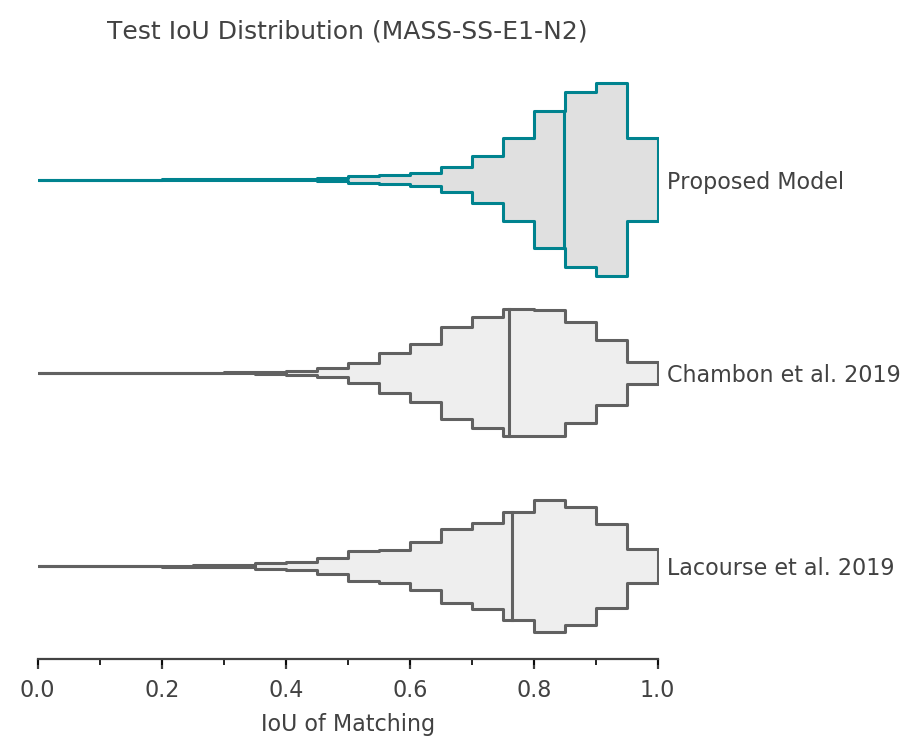

In [10]:
# Plot iou hist specs
smaller_plot = False
compare_baselines = True
figsize = (4, 4)
title = 'Test IoU Distribution (%s)' % result_id

# -------------------- P L O T ----------------------    
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)
label_txt_list = []
label_pos_list = []

# Model
this_center = 0

model_iou_bins = model_data_dict[constants.IOU_HIST_BINS]
model_iou_hist = model_data_dict[constants.IOU_HIST_VALUES].mean(axis=0)
x, y = plotter.piecewise_constant_histogram(model_iou_bins, model_iou_hist)
y_sep = 2 * y.max()
model_mean_iou = model_data_dict[constants.MEAN_IOU].mean()
idx_at_mean = plotter.find_bin_idx(model_mean_iou, model_iou_bins)
y_at_mean = model_iou_hist[idx_at_mean]
ax.plot(
    [model_mean_iou, model_mean_iou], [this_center + y_at_mean, this_center - y_at_mean],
    linewidth=viz.LINEWIDTH, color=viz.COMPARISON_COLORS['model'], zorder=25)
ax.fill_between(
    x, this_center + y, this_center - y,
    edgecolor=viz.COMPARISON_COLORS['model'], linewidth=viz.LINEWIDTH,
    facecolor=viz.GREY_COLORS[3], zorder=20)
label_txt_list.append(model_label)
label_pos_list.append(this_center)

if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_bins = bl_data[constants.IOU_HIST_BINS]
            bl_iou_hist = bl_data[constants.IOU_HIST_VALUES].mean(axis=0)
            x, y = plotter.piecewise_constant_histogram(bl_iou_bins, bl_iou_hist)
            this_center = this_center - y_sep
            bl_mean_iou = bl_data[constants.MEAN_IOU].mean()
            idx_at_mean = plotter.find_bin_idx(bl_mean_iou, bl_iou_bins)
            y_at_mean = bl_iou_hist[idx_at_mean]
            ax.plot(
                [bl_mean_iou, bl_mean_iou], [this_center + y_at_mean, this_center - y_at_mean],
                linewidth=viz.LINEWIDTH, color=viz.COMPARISON_COLORS['baseline'], zorder=25)
            ax.fill_between(
                x, this_center + y, this_center - y,
                edgecolor=viz.COMPARISON_COLORS['baseline'], linewidth=viz.LINEWIDTH,
                facecolor=viz.GREY_COLORS[2], zorder=20)
            label_txt_list.append(bl_label)
            label_pos_list.append(this_center)

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_iou_hist_plot(ax, label_pos_list, label_txt_list)
ax = plotter.set_axis_color(ax)
plt.show()

### Duration scatter

In [ ]:
duration_data = performer.duration_scatter_with_seeds(
    dataset,
    predictions_dict,
    optimal_thr_list,
    task_mode,
    which_expert)

In [ ]:
# Plot duration specs
smaller_plot = False
figsize = (8, 3.5)
n_bins = 30
min_dur = 0.2
max_dur = 2.0
alpha_scatter = 0.1
title = 'Duration Fitting (%s)' % result_id

# -------------------- P L O T ---------------------- 

x_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
y_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
mean_hist = []
all_expert_duration = []
all_detection_duration = []
for k in seed_id_list:
    expert_duration = []
    detection_duration = []
    for i, subject_id in enumerate(ids_dict['test']):
        expert_duration.append(duration_data[k]['expert_duration'][i])
        detection_duration.append(duration_data[k]['detection_duration'][i])
    expert_duration = np.concatenate(expert_duration) / fs
    detection_duration = np.concatenate(detection_duration) / fs
    hist, _, _ = np.histogram2d(
        expert_duration, detection_duration, bins=[x_bins, y_bins], density=True)
    mean_hist.append(hist)
    all_expert_duration.append(expert_duration)
    all_detection_duration.append(detection_duration)
mean_hist = np.stack(mean_hist, axis=0).mean(axis=0)
all_expert_duration = np.concatenate(all_expert_duration)
all_detection_duration = np.concatenate(all_detection_duration)

this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=this_dpi, sharey=True, sharex=True)
fig.suptitle(title, fontsize=viz.FONTSIZE_TITLE, color=viz.AXIS_COLOR)
xlabel = 'Real Duration [s]'
ylabel = 'Predicted Duration [s]'
# Histogram
x_centers = x_bins[:-1] + x_bins[1]/2 - x_bins[0]/2
y_centers = y_bins[:-1] + y_bins[1]/2 - y_bins[0]/2
xv, yv = np.meshgrid(x_centers, y_centers)
ax[0].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=mean_hist.flatten(), cmap='viridis')
ax[0].set_title('Density', fontsize=viz.FONTSIZE_TITLE, loc='center')
# scatter
ax[1].scatter(all_expert_duration, all_detection_duration, alpha=alpha_scatter, color=viz.COMPARISON_COLORS['model'])
ax[1].set_title('Scatter', fontsize=viz.FONTSIZE_TITLE, loc='center')

ax[0] = plotter.format_duration_scatter_plot(ax[0], min_dur, max_dur, xlabel, ylabel)
ax[0] = plotter.set_axis_color(ax[0])
ax[1] = plotter.format_duration_scatter_plot(ax[1], min_dur, max_dur, xlabel, None)
ax[1] = plotter.set_axis_color(ax[1])
plt.show()

### Precision-Recall curve

In [48]:
iou_thr_to_show = 0.2

pr_curve_data = performer.precision_recall_curve_with_seeds(
    dataset,
    predictions_dict,
    pr_curve_thr,
    iou_thr_to_show,
    task_mode,
    which_expert)
print('Done', flush=True)

Processing seed 0
Processing seed 1
Processing seed 2
Processing seed 3
Processing seed 4
Processing seed 5
Processing seed 6
Processing seed 7
Processing seed 8
Processing seed 9
Done


In [ ]:
# Plot PR curve specs
smaller_plot = False
external_legend = True
compare_expert = False
compare_baselines = True
show_iso_f1 = False
show_diagonal = True
alpha_curve = 0.7
figsize = (4, 4)
title = 'Test Performance with IoU$>$%1.1f (%s)' % (iou_thr_to_show, result_id)

# -------------------- P L O T ----------------------  
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)

# Model performance
op_idx = [misc.closest_index(optimal_thr_list[k], pr_curve_thr) for k in seed_id_list]
seeds_recall = [pr_curve_data[k][constants.RECALL] for k in seed_id_list]
seeds_precision = [pr_curve_data[k][constants.PRECISION] for k in seed_id_list]
mean_recall_op = np.mean([seeds_recall[k][op_idx[k]] for k in seed_id_list])
mean_precision_op = np.mean([seeds_precision[k][op_idx[k]] for k in seed_id_list])
mean_recall_curve, mean_precision_curve = plotter.average_curves(seeds_recall, seeds_precision)
ax.plot(
    mean_recall_curve, mean_precision_curve,
    linewidth=viz.LINEWIDTH, color=viz.COMPARISON_COLORS['model'], zorder=10, alpha=alpha_curve)
ax.plot(
    mean_recall_op, mean_precision_op, label=model_label,
    linestyle="None", color=viz.COMPARISON_COLORS['model'], zorder=20, marker='o', 
    markersize=viz.MARKERSIZE)

# Baselines
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_recall_vs_iou_mean = bl_data[constants.RECALL_VS_IOU].mean(axis=0)
            bl_precision_vs_iou_mean = bl_data[constants.PRECISION_VS_IOU].mean(axis=0)
            useful_idx = misc.closest_index(iou_thr_to_show, bl_iou_axis)
            bl_recall = bl_recall_vs_iou_mean[useful_idx]
            bl_precision = bl_precision_vs_iou_mean[useful_idx]
            ax.plot(
                bl_recall, bl_precision, 
                markersize=viz.MARKERSIZE, c=viz.COMPARISON_COLORS['baseline'], zorder=15, 
                label=bl_label, marker=bl_marker, linestyle="None")

# Expert
if compare_expert and (dataset.event_name == constants.SPINDLE):
    ax.plot(
        expert_data_dict[constants.RECALL], expert_data_dict[constants.PRECISION], 
        markersize=viz.COMPARISON_COLORS, c=viz.COMPARISON_COLORS['expert'], zorder=10, 
        label='Expert Performance\nWarby et al. 2014\nPrivate Dataset', marker='o', linestyle="None")

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_precision_recall_plot(ax, show_diagonal, show_iso_f1)
lg = plotter.format_legend(ax, external_legend)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
plt.show()

### Complete chart

Database: mass_kc, Expert: 1
IoU to show: 0.2
F1 82.33/0.42, Recall 81.87/0.90, Precision 83.66/0.42, AF1 74.74/0.35, IoU 90.44/0.18 for Proposed Model
F1 77.13/0.80, Recall 76.54/1.19, Precision 78.56/1.81, AF1 57.04/1.29, IoU 73.26/1.06 for Chambon et al. 2019
F1 64.87/0.03, Recall 62.58/0.54, Precision 68.72/0.61, AF1 28.58/0.01, IoU 43.53/0.04 for Lajnef et al. 2017


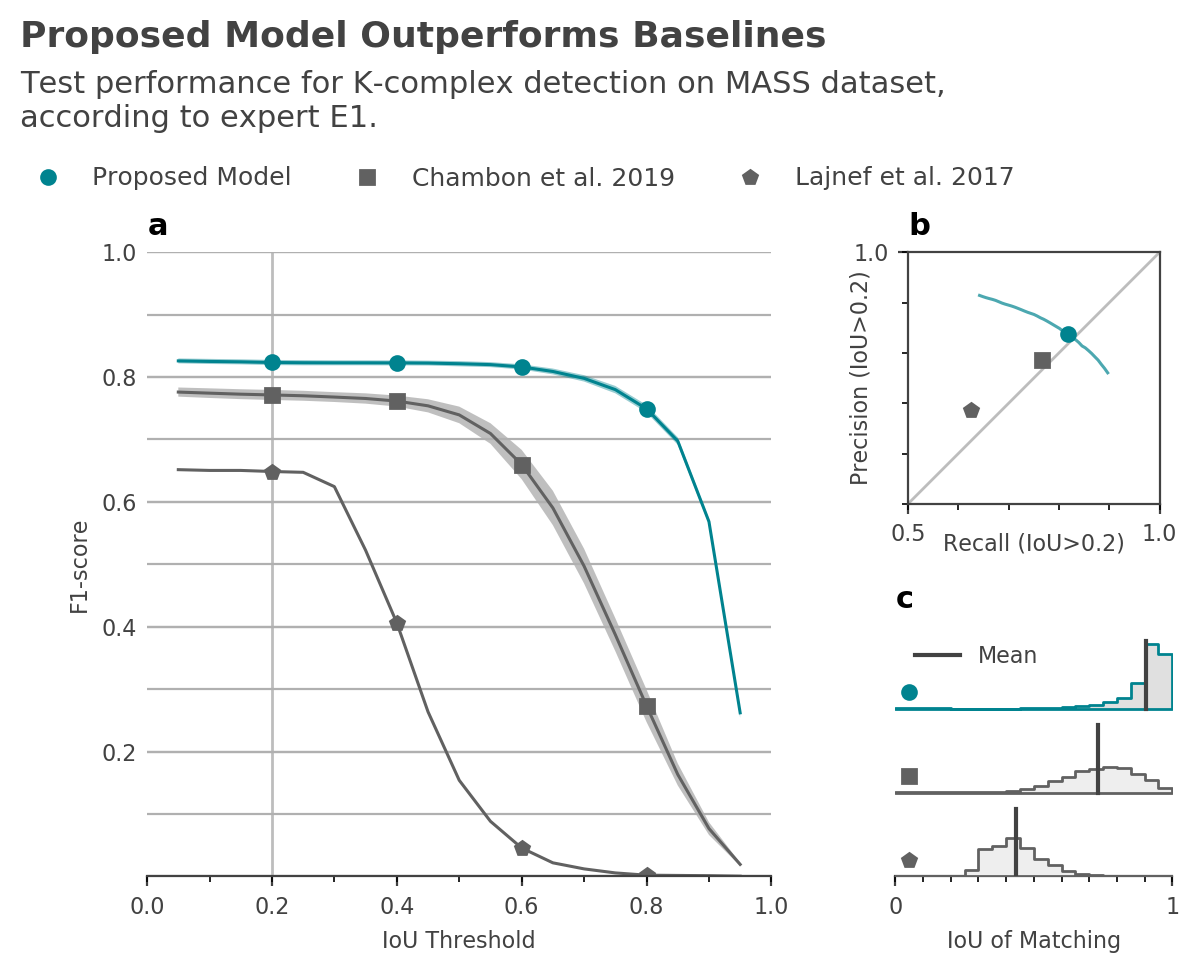

In [49]:
# Plot specs
smaller_plot = False
compare_expert = False
compare_baselines = True
iou_thr_to_show = 0.2
f1_show_seed_std = True
f1_alpha_seed_std = 0.4
f1_alpha_expert = 0.5
f1_markers_iou = [0.2, 0.4, 0.6, 0.8]
pr_show_iso_f1 = False
pr_show_diagonal = True
pr_alpha_curve = 0.7
pr_axis_lims = [0.5, 1.0]
pr_major_ticks = [0.5, 1.0]
pr_minor_ticks = np.linspace(0.5, 1, 6)
iou_major_ticks= [0, 1]
figsize = (6, 4)
chart_label_fontsize = 11
title = 'Title (%s)' % result_id

print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
this_dpi = 100 if smaller_plot else viz.DPI
fig = plt.figure(figsize=figsize, dpi=this_dpi)
gs = fig.add_gridspec(2, 3)

# -----------------------------
# ----------------------------- F1 vs IoU
# -----------------------------
ax = fig.add_subplot(gs[:, :2])
mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
idx_markers_iou = [
    misc.closest_index(single_marker, iou_curve_axis) 
    for single_marker in f1_markers_iou]
ax.plot(
    iou_curve_axis, mean_f1_vs_iou, linewidth=viz.LINEWIDTH, zorder=20, marker='o', label=model_label,
    color=viz.COMPARISON_COLORS['model'], markersize=viz.MARKERSIZE, markevery=idx_markers_iou)
if f1_show_seed_std:
    ax.fill_between(
        iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
        alpha=f1_alpha_seed_std, facecolor=viz.COMPARISON_COLORS['model'], zorder=20)
printer.print_performance_at_iou(model_data_dict, iou_thr_to_show, model_label)
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_f1_vs_iou_mean = bl_data[constants.F1_VS_IOU].mean(axis=0)
            bl_f1_vs_iou_std = bl_data[constants.F1_VS_IOU].std(axis=0)
            idx_markers_iou = [
                misc.closest_index(single_marker, bl_iou_axis) 
                for single_marker in f1_markers_iou]
            ax.plot(
                bl_iou_axis, bl_f1_vs_iou_mean, linewidth=viz.LINEWIDTH, marker=bl_marker, 
                label=bl_label, color=viz.COMPARISON_COLORS['baseline'], markersize=viz.MARKERSIZE, 
                markevery=idx_markers_iou)
            if f1_show_seed_std:
                ax.fill_between(
                    bl_iou_axis, bl_f1_vs_iou_mean - bl_f1_vs_iou_std, bl_f1_vs_iou_mean + bl_f1_vs_iou_std, 
                    alpha=f1_alpha_seed_std, facecolor=viz.COMPARISON_COLORS['baseline'])
            printer.print_performance_at_iou(bl_data, iou_thr_to_show, bl_label)
if compare_expert and (dataset.event_name == constants.SPINDLE):
    exp_mean_f1 = expert_data_dict['%s_mean' % constants.F1_VS_IOU]
    exp_std_f1 = expert_data_dict['%s_std' % constants.F1_VS_IOU]
    exp_iou_axis = expert_data_dict[constants.IOU_CURVE_AXIS]
    min_border = exp_mean_f1 - exp_std_f1
    max_border = exp_mean_f1 + exp_std_f1
    denser_iou, max_border = plotter.densify_curve(exp_iou_axis, max_border)
    denser_iou, min_border = plotter.densify_curve(exp_iou_axis, min_border)
    ax.fill_between(
        denser_iou, min_border, max_border, alpha=f1_alpha_expert, facecolor=viz.COMPARISON_COLORS['expert'], 
        label='Expert Performance\nWarby et al. 2014\nPrivate Dataset')
ax = plotter.add_label_chart(ax, 'a', chart_label_fontsize)
ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
ax = plotter.set_axis_color(ax)
ax.set_aspect('equal', 'box')


# -----------------------------
# ----------------------------- PR curve
# -----------------------------
ax = fig.add_subplot(gs[0, 2])
op_idx = [misc.closest_index(optimal_thr_list[k], pr_curve_thr) for k in seed_id_list]
seeds_recall = [pr_curve_data[k][constants.RECALL] for k in seed_id_list]
seeds_precision = [pr_curve_data[k][constants.PRECISION] for k in seed_id_list]
mean_recall_op = np.mean([seeds_recall[k][op_idx[k]] for k in seed_id_list])
mean_precision_op = np.mean([seeds_precision[k][op_idx[k]] for k in seed_id_list])
mean_recall_curve, mean_precision_curve = plotter.average_curves(seeds_recall, seeds_precision)
ax.plot(
    mean_recall_curve, mean_precision_curve,
    linewidth=viz.LINEWIDTH, color=viz.COMPARISON_COLORS['model'], zorder=10, alpha=pr_alpha_curve)
ax.plot(
    mean_recall_op, mean_precision_op, label=model_label,
    linestyle="None", color=viz.COMPARISON_COLORS['model'], zorder=20, marker='o', 
    markersize=viz.MARKERSIZE)
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_axis = bl_data[constants.IOU_CURVE_AXIS]
            bl_recall_vs_iou_mean = bl_data[constants.RECALL_VS_IOU].mean(axis=0)
            bl_precision_vs_iou_mean = bl_data[constants.PRECISION_VS_IOU].mean(axis=0)
            useful_idx = misc.closest_index(iou_thr_to_show, bl_iou_axis)
            bl_recall = bl_recall_vs_iou_mean[useful_idx]
            bl_precision = bl_precision_vs_iou_mean[useful_idx]
            ax.plot(
                bl_recall, bl_precision, 
                markersize=viz.MARKERSIZE, c=viz.COMPARISON_COLORS['baseline'], zorder=15, 
                label=bl_label, marker=bl_marker, linestyle="None")
if compare_expert and (dataset.event_name == constants.SPINDLE):
    ax.plot(
        expert_data_dict[constants.RECALL], expert_data_dict[constants.PRECISION], 
        markersize=viz.COMPARISON_COLORS, c=viz.COMPARISON_COLORS['expert'], zorder=10, 
        label='Expert Performance\nWarby et al. 2014\nPrivate Dataset', marker='o', linestyle="None")
ax = plotter.add_label_chart(ax, 'b', chart_label_fontsize)
ax = plotter.format_precision_recall_plot(
    ax, pr_show_diagonal, pr_show_iso_f1,
    axis_lims=pr_axis_lims,
    pr_major_ticks=pr_major_ticks,
    pr_minor_ticks=pr_minor_ticks)
ax.set_xlabel('Recall (IoU>%1.1f)' % iou_thr_to_show, fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('Precision (IoU>%1.1f)' % iou_thr_to_show, fontsize=viz.FONTSIZE_GENERAL)

ax = plotter.set_axis_color(ax)
ax.xaxis.labelpad = -5
ax.yaxis.labelpad = -7
ax.set_aspect('equal', 'box')
# This subplots provides the legend specs
handles, labels = ax.get_legend_handles_labels()

# -----------------------------
# ----------------------------- IoU hist
# -----------------------------
ax = fig.add_subplot(gs[1, 2])
model_iou_bins = model_data_dict[constants.IOU_HIST_BINS]
model_iou_hist = model_data_dict[constants.IOU_HIST_VALUES].mean(axis=0)
x, y = plotter.piecewise_constant_histogram(model_iou_bins, model_iou_hist)
y_sep = 1.3*y.max()
this_center = 0
model_mean_iou = model_data_dict[constants.MEAN_IOU].mean()
idx_at_mean = plotter.find_bin_idx(model_mean_iou, model_iou_bins)
y_at_mean = model_iou_hist[idx_at_mean]
ax.plot(
    [model_mean_iou, model_mean_iou], [this_center, this_center + 0.8*y_sep],
    linewidth=1.5, color=viz.AXIS_COLOR, zorder=25, label='Mean')
ax.fill_between(
    x, this_center + y, this_center,
    edgecolor=viz.COMPARISON_COLORS['model'], linewidth=1,
    facecolor=viz.GREY_COLORS[3], zorder=20)
ax.plot(
    0.05, this_center + 0.2*y_sep, 
    markersize=viz.MARKERSIZE, c=viz.COMPARISON_COLORS['model'], zorder=15, 
    marker='o', linestyle="None")
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bl_data = baselines_data_dict[baseline_name]
        if bl_data is not None:
            bl_label = viz.BASELINES_LABEL_MARKER[baseline_name][0]
            bl_marker = viz.BASELINES_LABEL_MARKER[baseline_name][1]
            bl_iou_bins = bl_data[constants.IOU_HIST_BINS]
            bl_iou_hist = bl_data[constants.IOU_HIST_VALUES].mean(axis=0)
            x, y = plotter.piecewise_constant_histogram(bl_iou_bins, bl_iou_hist)
            this_center = this_center - y_sep
            bl_mean_iou = bl_data[constants.MEAN_IOU].mean()
            idx_at_mean = plotter.find_bin_idx(bl_mean_iou, bl_iou_bins)
            y_at_mean = bl_iou_hist[idx_at_mean]
            ax.plot(
                [bl_mean_iou, bl_mean_iou], [this_center, this_center + 0.8*y_sep],
                linewidth=1.5, color=viz.AXIS_COLOR, zorder=25)
            ax.fill_between(
                x, this_center + y, this_center,
                edgecolor=viz.COMPARISON_COLORS['baseline'], linewidth=1,
                facecolor=viz.GREY_COLORS[2], zorder=20)
            ax.plot(
                0.05, this_center + 0.2*y_sep, 
                markersize=viz.MARKERSIZE, c=viz.COMPARISON_COLORS['baseline'], zorder=15, 
                marker=bl_marker, linestyle="None")
ax = plotter.add_label_chart(ax, 'c', chart_label_fontsize)
label_txt_list = []
label_pos_list = []
ax = plotter.format_iou_hist_plot(
    ax, label_pos_list, label_txt_list,
    iou_major_ticks=iou_major_ticks)
lg = ax.legend(loc='upper left', fontsize=viz.FONTSIZE_GENERAL, frameon=False)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
ax.set_ylim([this_center, y_sep])

plt.tight_layout()

lg = fig.legend(
    handles, labels, 
    loc='lower left', 
    labelspacing=viz.LEGEND_LABEL_SPACING,
    fontsize=viz.FONTSIZE_TITLE, 
    frameon=False, 
    bbox_to_anchor=(0, 0.95), 
    ncol=4
)
lg = plotter.set_legend_color(lg)

plt.text(
    x=0.0, y=1.17, fontsize=13, 
    s='Proposed Model Outperforms Baselines', 
    ha="left", transform=fig.transFigure, weight='bold', color=viz.AXIS_COLOR)
if dataset.event_name == constants.SPINDLE:
    event_name_title = 'sleep spindle'
elif dataset.event_name == constants.KCOMPLEX:
    event_name_title = 'K-complex'
else:
    raise ValueError('Event %s not supported' % dataset.event_name)
subtitle_str = 'Test performance for %s detection on %s dataset,\naccording to expert E%d.' % (
    event_name_title, dataset.dataset_name.split("_")[0].upper(), which_expert
)
plt.text(
    x=0.0, y=1.07, fontsize=11, 
    s=subtitle_str, 
    ha="left", transform=fig.transFigure, color=viz.AXIS_COLOR)

plt.show()

# Performance on Individual Subjects (Messy)

## F1 vs IoU by subject

Processing train
Processing val
Done
Processing train
Processing val
Done
Processing train
Processing val
Done
Processing train
Processing val
Done


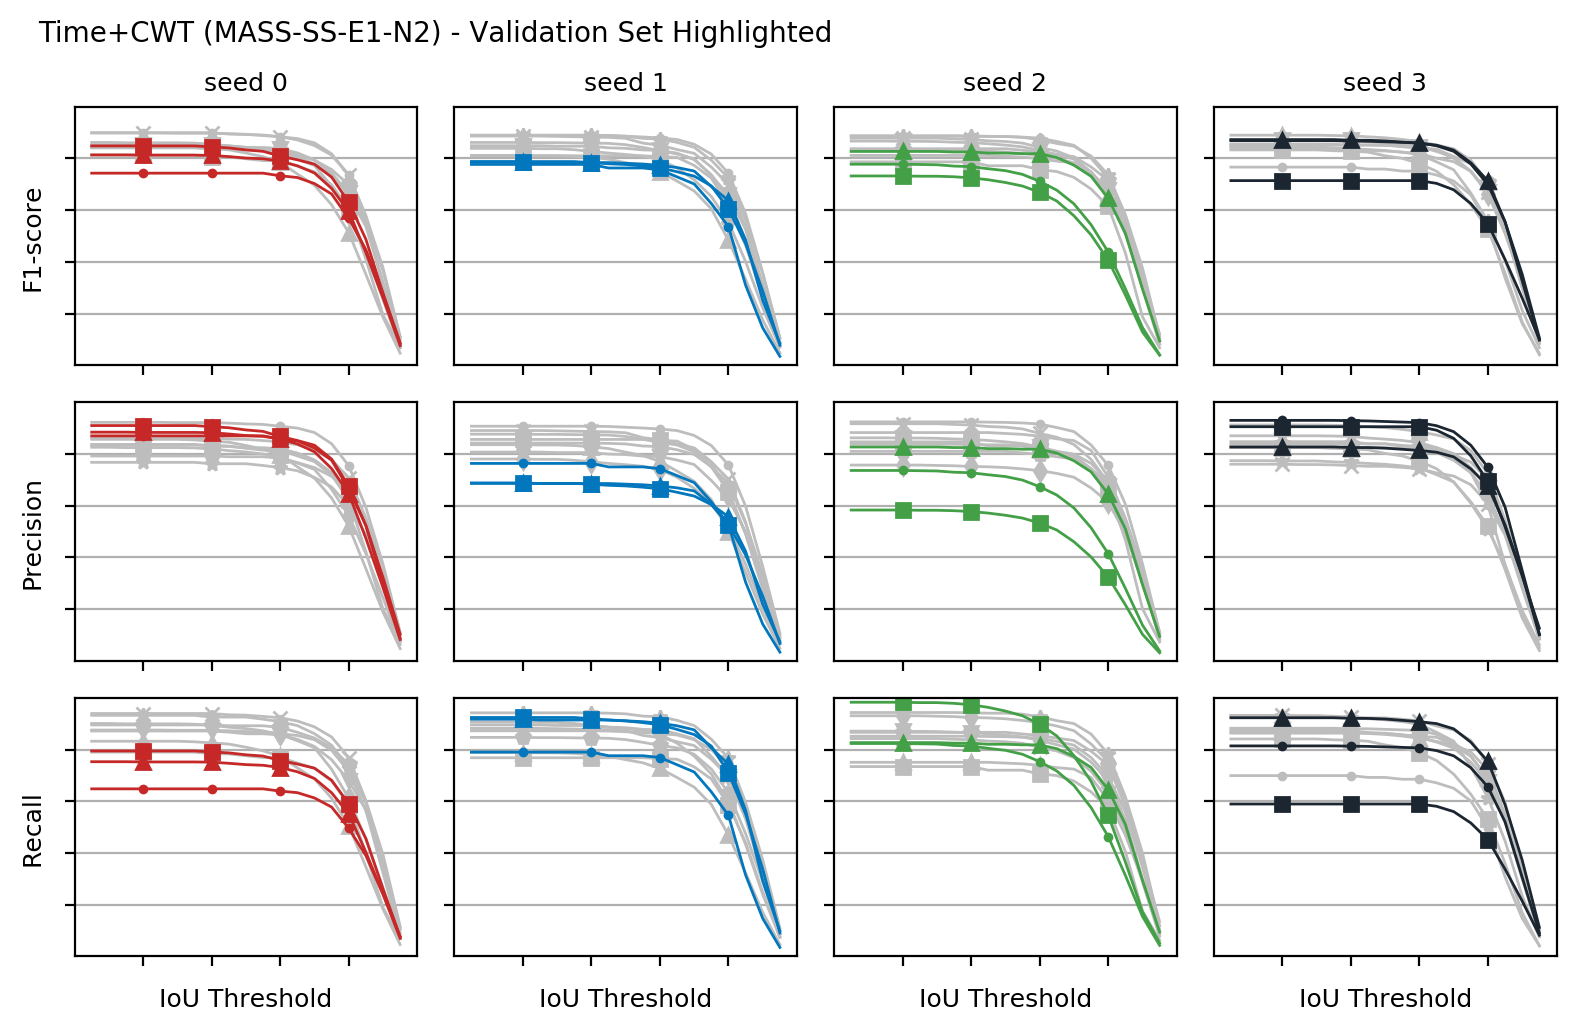

In [10]:
seeds_to_show = [0, 1, 2, 3]
n_seeds = len(seeds_to_show)
t_label = 'Time+CWT'
set_list = ['train', 'val']

fig, ax = plt.subplots(3, n_seeds, figsize=(2*n_seeds, 5), dpi=viz.DPI)
# f1_color = {'train':  , 'val': viz.PALETTE['red']}
# prec_color = {'train': viz.GREY_COLORS[4] , 'val': viz.PALETTE['blue']}
# rec_color = {'train': viz.GREY_COLORS[4] , 'val': viz.PALETTE['green']}
color_dict = {
    'train': {i: viz.GREY_COLORS[4] for i in range(4)},
    'val': {0: viz.PALETTE['red'], 1: viz.PALETTE['blue'], 2: viz.PALETTE['green'], 3: viz.PALETTE['dark']}
}

marker_list = ['.', 's', '^', 'x', '*', 'd', 'v', 'p']
linewidth_model = 1
markersize_model = 5
f1_markers_iou = [0.2, 0.4, 0.6, 0.8]
idx_markers_iou = [
    misc.closest_index(single_marker, iou_curve_axis) 
    for single_marker in f1_markers_iou]
    
for k_ax, seed_id_for_f1vsiou in enumerate(seeds_to_show):
    # ---------------- Compute performance
    f1_vs_iou_subject_dict = {}
    pre_vs_iou_subject_dict = {}
    rec_vs_iou_subject_dict = {}
    for set_name in set_list:
        print('Processing %s' % set_name, flush=True)
        # Prepare expert labels
        data_inference = FeederDataset(
            dataset, ids_dict[seed_id_for_f1vsiou][set_name], task_mode, which_expert)
        this_ids = data_inference.get_ids()
        this_events_list = data_inference.get_stamps()
        # Prepare model predictions
        prediction_obj = predictions_dict[seed_id_for_f1vsiou][set_name]
        prediction_obj.set_probability_threshold(optimal_thr_list[seed_id_for_f1vsiou])
        this_detections_list = prediction_obj.get_stamps()
        for i, single_id in enumerate(this_ids):
            single_events = this_events_list[i]
            single_detections = this_detections_list[i]
            this_precision = metrics.metric_vs_iou(
                single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
            this_recall = metrics.metric_vs_iou(
                single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
            this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall + 1e-8)
            pre_vs_iou_subject_dict[single_id] = this_precision
            rec_vs_iou_subject_dict[single_id] = this_recall
            f1_vs_iou_subject_dict[single_id] = this_f1
    print('Done', flush=True)

    # -------------------- P L O T ----------------------    

    for set_name in set_list:
        for i, single_id in enumerate(ids_dict[seed_id_for_f1vsiou][set_name]):
            # F1-score
            ax[0, k_ax].plot(iou_curve_axis, f1_vs_iou_subject_dict[single_id], 
                       linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                       label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)
            # Precision
            ax[1, k_ax].plot(iou_curve_axis, pre_vs_iou_subject_dict[single_id], 
                       linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                       label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)
            # Recall
            ax[2, k_ax].plot(iou_curve_axis, rec_vs_iou_subject_dict[single_id], 
                       linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                       label='S%02d' % single_id, color=color_dict[set_name][k_ax], markevery=idx_markers_iou)

    ax[0, k_ax].set_title('seed %d' % (seed_id_for_f1vsiou), fontsize=9)
for s_ax in ax.flatten():
    s_ax.set_xlim([0, 1])
    s_ax.set_ylim([0, 1])
    s_ax.set_yticks([0.1*i for i in range(2, 10, 2)])
    s_ax.set_xticks([0.1*i for i in range(2, 10, 2)])
    s_ax.set_xticklabels([])
    s_ax.set_yticklabels([])
    s_ax.tick_params(labelsize=8.5)
    s_ax.yaxis.grid()       
ax[0, 0].set_ylabel('F1-score', fontsize=9)
ax[1, 0].set_ylabel('Precision', fontsize=9)
ax[2, 0].set_ylabel('Recall', fontsize=9)
for s_ax in ax[2, :]:
    s_ax.set_xticks([0.1*i for i in range(2, 10, 2)])
    s_ax.set_xlabel('IoU Threshold', fontsize=9)
plt.tight_layout()
plt.text(
    x=0.03, y=1.0, fontsize=10, 
    s='%s (%s) - Validation Set Highlighted' % (t_label, result_id), 
    ha="left", transform=fig.transFigure)
plt.show()

Processing train
Processing val
Done
Processing train
Processing val
Done
Processing train
Processing val
Done
Processing train
Processing val
Done


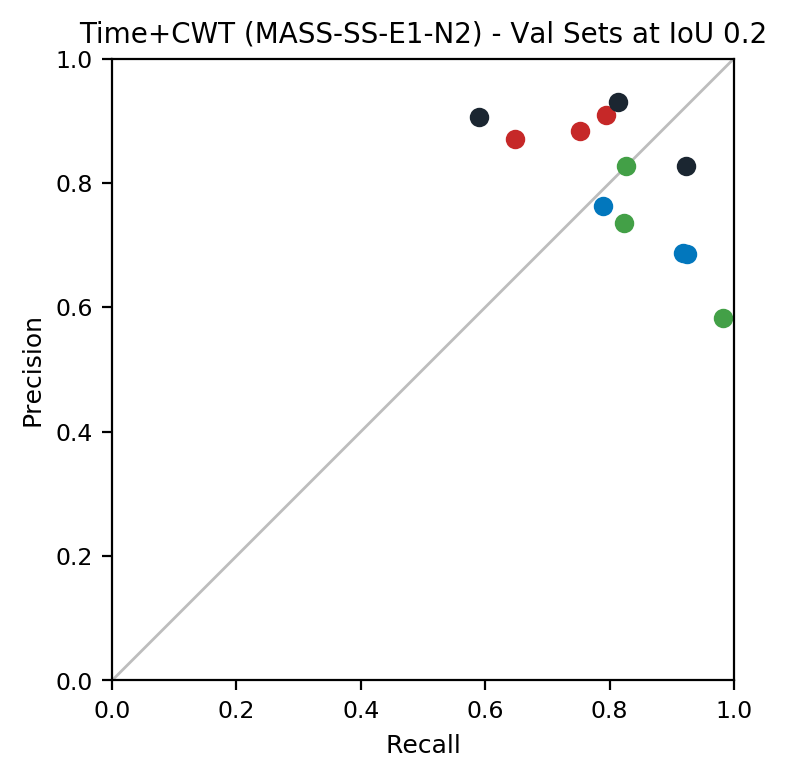

In [11]:
seeds_to_show = [0, 1, 2, 3]
n_seeds = len(seeds_to_show)
t_label = 'Time+CWT'
set_list = ['train', 'val']
iou_to_show = 0.2
iou_idx = misc.closest_index(iou_to_show, iou_curve_axis) 

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=viz.DPI)
color_dict = {
    'train': {i: viz.GREY_COLORS[4] for i in range(4)},
    'val': {0: viz.PALETTE['red'], 1: viz.PALETTE['blue'], 2: viz.PALETTE['green'], 3: viz.PALETTE['dark']}
}

markersize_model = 6
axis_markers = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
for k_ax, seed_id_for_f1vsiou in enumerate(seeds_to_show):
    # ---------------- Compute performance
    pre_vs_iou_subject_dict = {}
    rec_vs_iou_subject_dict = {}
    for set_name in set_list:
        print('Processing %s' % set_name, flush=True)
        # Prepare expert labels
        data_inference = FeederDataset(
            dataset, ids_dict[seed_id_for_f1vsiou][set_name], task_mode, which_expert)
        this_ids = data_inference.get_ids()
        this_events_list = data_inference.get_stamps()
        # Prepare model predictions
        prediction_obj = predictions_dict[seed_id_for_f1vsiou][set_name]
        prediction_obj.set_probability_threshold(optimal_thr_list[seed_id_for_f1vsiou])
        this_detections_list = prediction_obj.get_stamps()
        for i, single_id in enumerate(this_ids):
            single_events = this_events_list[i]
            single_detections = this_detections_list[i]
            this_precision = metrics.metric_vs_iou(
                single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
            this_recall = metrics.metric_vs_iou(
                single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
            pre_vs_iou_subject_dict[single_id] = this_precision
            rec_vs_iou_subject_dict[single_id] = this_recall
    print('Done', flush=True)

    # -------------------- P L O T ----------------------    

    for set_name in ['val']:
        for i, single_id in enumerate(ids_dict[seed_id_for_f1vsiou][set_name]):
            ax.plot(
                rec_vs_iou_subject_dict[single_id][iou_idx], 
                pre_vs_iou_subject_dict[single_id][iou_idx],
                color=color_dict[set_name][k_ax], marker='o', markersize=markersize_model
            )
ax.plot([0, 1], [0, 1], zorder=1, linewidth=1, color=viz.GREY_COLORS[4])
ax.set_title('%s (%s) - Val Sets at IoU %1.1f' % (t_label, result_id, iou_to_show), fontsize=10)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticks(axis_markers)
ax.set_xticks(axis_markers)
ax.tick_params(labelsize=8.5) 
ax.set_ylabel('Precision', fontsize=9)
ax.set_xlabel('Recall', fontsize=9)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [ ]:
# PR by subject, usando APrecision y ARecall
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 10
text_space = 0.01
show_ids = True
axis_lims = [0, 1]
show_set_list = ['train', 'val', 'test']

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=6, fmt='%1.2f')

for set_name in set_list:
    if set_name in show_set_list:
        for i, single_id in enumerate(ids_dict[set_name]):
            if i==0:
                label = 'Proposed (%s) (%s)' % (task_mode.upper(), set_name.capitalize())
            else:
                label = None
            this_arecall = rec_vs_iou_subject_dict[single_id].mean()
            this_aprecision = pre_vs_iou_subject_dict[single_id].mean()
            ax.scatter(
                this_arecall, this_aprecision, 
                c=color_list[set_name], 
                label=label, marker='s',
                s=markersize, zorder=10)
            if show_ids:
                ax.annotate(
                    single_id, 
                    (this_arecall+text_space, this_aprecision+text_space), 
                    fontsize=7, color='#1b2631', zorder=20) 
ax.set_title('Seed %d ($\mu$=%1.2f)' % (seed_id_for_f1vsiou, optimal_thr_list[seed_id_for_f1vsiou]), fontsize=7)
ax.set_xlabel('A-Recall', fontsize=7)
ax.set_ylabel('A-Precision', fontsize=7)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)
ax.tick_params(labelsize=7)
ax.legend(loc='lower left', fontsize=5)
ax.grid()
plt.show()

## Performance: Precision-Recall curve, average per set

In [ ]:
iou_thr = 0.2

res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve = {}
# Prepare expert labels
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()
this_signals = data_test.get_signals()
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    # Columns are [x: recall, y: precision]
    pr_curve[k] = np.zeros((n_thr, 2))
    for i, thr in enumerate(thr_list):
        # Prepare model predictions
        prediction_test = predictions_dict[k][constants.TEST_SUBSET]
        prediction_test.set_probability_threshold(thr)
        this_detections = prediction_test.get_stamps()
        
        #if dataset_name == constants.MASS_KC_NAME:
        #    new_detections = []
        #    print('Postprocessing')
        #    for single_detection, single_signal in zip(this_detections, this_signals):
        #        single_detection = postprocessing.kcomplex_stamp_split(
        #            single_signal, single_detection, fs)
        #        new_detections.append(single_detection)
        #    this_detections = new_detections
        
        this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                    for (this_y, this_y_pred) in zip(this_events, this_detections)]
        this_recall = np.mean([m[constants.RECALL] for m in this_stats])
        this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
        pr_curve[k][i, 0] = this_recall
        pr_curve[k][i, 1] = this_precision

# Mean of runs
# pr_curve['mean_runs'] = np.stack([pr_curve[k] for k in seed_id_list], axis=2).mean(axis=2)
print('Done', flush=True)

In [ ]:
# Save
filename = '%s_pr_curve.npy' % (ckpt_folder.split('/')[0])
data = []
this_thr = np.asarray(thr_list)[:, np.newaxis]
for k in seed_id_list:
    this_pr = pr_curve[k]
    this_pr = np.concatenate([this_thr, this_pr], axis=1)
    data.append(this_pr)
data = np.stack(data, axis=0).astype(np.float32)
np.save(filename, data)

In [ ]:
# Plot 
bsf_name = 'Proposed Model'
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper()
)

markersize = 6
alpha = 0.5
text_space = 0.01
compare_chambon = False
compare_baselines = True
compare_expert = False
# show_seeds = True
axis_lims = [0.0, 1.0]
pr_major_ticks = np.linspace(0, 1, 6)
pr_minor_ticks = np.linspace(0, 1, 11)

smaller_plot = False
external_legend = True
show_iso_f1 = False
show_diagonal = True

color_list = {'model_mean': CUSTOM_COLOR['cyan'] , 'expert': CUSTOM_COLOR['blue'], 'dosed': viz.PALETTE['dark'],
              'generic_baseline': GREY_COLORS[8]
             }

if smaller_plot:
    this_dpi = 100
else:
    this_dpi = DPI
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=this_dpi)

# F1 score levels
if show_iso_f1:
    delta = 0.01 
    x_ = np.arange(1, 100) * delta 
    y_ = np.arange(1, 100) * delta 
    X, Y = np.meshgrid(x_, y_)
    Z = 2 * X * Y / (X + Y)

    levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

    CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

# Mean of seeds
seeds_recall = []
seeds_precision = []
mean_recall_op = []
mean_precision_op = []
for k in seed_id_list:
    chosen_thr_idx = np.where(np.isclose(thr_list, optimal_thr_list[k]))[0].item()
    this_recall = pr_curve[k][:, 0]
    this_precision = pr_curve[k][:, 1]
    seeds_recall.append(this_recall)
    seeds_precision.append(this_precision)
    mean_recall_op.append(this_recall[chosen_thr_idx])
    mean_precision_op.append(this_precision[chosen_thr_idx])
mean_recall_op = np.mean(mean_recall_op)
mean_precision_op = np.mean(mean_precision_op)
mean_recall_curve, mean_precision_curve = average_curves(seeds_recall, seeds_precision)
ax.plot(
    mean_recall_curve, mean_precision_curve,
    linewidth=1.1, color=color_list['model_mean'], zorder=10, alpha=0.7)
ax.plot(
    mean_recall_op, mean_precision_op, label=bsf_name,
    linestyle="None", color=color_list['model_mean'], zorder=20, marker='o', 
    markersize=markersize)
    
#if show_seeds:
    # Show single seeds
    #seed_shown = False
    #for k in seed_id_list:
        #if not seed_shown:
        #    seed_shown=True
        #    label = '%s (Seeds)' % bsf_name
        #    if show_half_thr:
        #        label_2 = '%s (Seed 0.5 O.P.)' % bsf_name
        #    else:
        #        label_2 = '%s (Seed O.P.)' % bsf_name
        #else:
        #    label = None
        #    label_2 = None
    
        #chosen_thr_idx = np.where(np.isclose(thr_list, optimal_thr_list[k]))[0].item()

        # ax.plot(
        #     pr_curve[k][:, 0], pr_curve[k][:, 1], label=label,
        #    linewidth=1, color=color_list['model_mean'], zorder=20, alpha=alpha, marker='o', 
        #    markersize=markersize, markevery=[chosen_thr_idx])
        #ax.plot(
        #    pr_curve[k][:, 0], pr_curve[k][:, 1], 
        #    linestyle="None", color=color_list['model_mean'], zorder=20, marker='o', 
        #    markersize=markersize, markevery=[chosen_thr_idx], alpha=0.6)
            
        # ax.scatter(pr_curve[k][chosen_thr_idx, 0], pr_curve[k][chosen_thr_idx, 1], 
        #            s=50, c=color_list['model_mean'], zorder=20, alpha=alpha, label=label_2)
    
if compare_baselines:
    for baseline_name in baselines_names_to_show:
        bs_recall_data = baselines_recall_dict[baseline_name]
        if bs_recall_data is not None:
            bs_precision_data = baselines_precision_dict[baseline_name]
            
            bl_label = baselines_plot_dict[baseline_name][0]
            bl_marker = baselines_plot_dict[baseline_name][1]
            
            bl_iou_axis = bs_recall_data[:, 0]
            useful_idx = np.argmin((bl_iou_axis - iou_thr)**2)
            bl_recall = bs_recall_data[useful_idx, 1:].mean()
            bl_precision = bs_precision_data[useful_idx, 1:].mean()
            ax.plot(
                bl_recall, bl_precision, 
                markersize=markersize, c=color_list['generic_baseline'], zorder=15, 
                label=bl_label, marker=bl_marker, linestyle="None")

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=markersize, c=color_list['dosed'], zorder=10, 
            label='Chambon et al. 2019 (WN, Paper)', marker='o', linestyle="None")
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=markersize, c=color_list['dosed'], zorder=10, 
            label='Chambon et al. 2019 (WN, Paper)', marker='o', linestyle="None")

if compare_expert:
    expert_rec_prec = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'expert', 'ss_pr_expert_mean.csv'), delimiter=',')
    ax.plot(expert_rec_prec[0], expert_rec_prec[1], 
           markersize=markersize, c=color_list['expert'], zorder=10, 
            label='Expert Performance\nWarby et al. 2014\nPrivate Dataset', marker='o', linestyle="None")
    
# Mean of runs
# ax.plot(pr_curve['mean_runs'][:, 0], pr_curve['mean_runs'][:, 1], 
#         label='%s (Mean)' % bsf_name,
#         linewidth=1.5, color=color_list['model_mean'], zorder=10)

# Highlight chosen operating point
# chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
# ax.scatter(pr_curve['mean_runs'][chosen_thr_idx, 0], pr_curve['mean_runs'][chosen_thr_idx, 1], 
#            s=50, c=color_list['model_mean'], zorder=10, label='Operating point $\mu$=%1.2f' % thr_run)
# ax.annotate('$\mu$=%1.3f' % thr_run, 
#             (pr_curve['mean_runs'][chosen_thr_idx, 0], 
#              pr_curve['mean_runs'][chosen_thr_idx, 1] + text_space*2), 
#             fontsize=7, color='#1b2631', zorder=30)  

# Show bisectrix
if show_diagonal:
    ax.plot(axis_lims, axis_lims, linewidth=1, color=GREY_COLORS[4], zorder=1)

ax.set_title('Test Performance with IoU$>$%1.1f (%s)' % (iou_thr, result_id), fontsize=9)
ax.set_xlabel('Recall', fontsize=8)
ax.set_ylabel('Precision', fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)
ax.set_yticks(pr_major_ticks[1:])
ax.set_yticks(pr_minor_ticks, minor=True)
ax.set_xticks(pr_major_ticks)
ax.set_xticks(pr_minor_ticks, minor=True)
# ax.xaxis.grid()
# ax.yaxis.grid()

if external_legend:
    lg = ax.legend(
        loc='lower left', labelspacing=1.1, fontsize=8, bbox_to_anchor=(1, 0), ncol=1, frameon=False
    )
else:
    lg = ax.legend(loc='lower left', labelspacing=1.1, fontsize=8, frameon=False)

for lh in lg.legendHandles:
    lh.set_alpha(1.0)
    lh._legmarker.set_alpha(1.0)

# Change color of plot
plt.setp(lg.get_texts(), color=GREY_COLORS[8])
ax = set_axis_color(ax, GREY_COLORS[8])

plt.show()

## Performance: Precision-Recall plot, separated subjects

In [ ]:
iou_thr = 0.3

# Prepare model predictions
be_stats = {}
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    be_stats[k] = {}
    if new_split_version:
        train_ids, val_ids = utils.split_ids_list_v2(
            all_train_ids, split_id=k)
    else:
        train_ids, val_ids = utils.split_ids_list(
            all_train_ids, seed=SEED_LIST[k])
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    for set_name in set_list:
        data_feeder = FeederDataset(
            dataset, ids_per_set_dict[set_name], task_mode, which_expert=which_expert)
        this_events = data_feeder.get_stamps()
        prediction_set = predictions_dict[k][set_name]
        prediction_set.set_probability_threshold(optimal_thr_list[k])
        this_detections = prediction_set.get_stamps()
        be_stats[k][set_name] = [
            metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
            for (this_y, this_y_pred) in zip(this_events, this_detections)]
print('Done')

In [ ]:
# Plot 
bsf_name = 'Proposed (%s)' % task_mode.upper()
fig, ax = plt.subplots(1, n_seeds, figsize=(2.3*n_seeds, 2.3), dpi=DPI)
markersize = 10
alpha = 0.3
text_space = 0.01
compare_chambon = False
show_ids = True
axis_lims = [0.5, 1.0]
show_set_list = ['train', 'val', 'test']
color_list = {'train': CUSTOM_COLOR['green'] , 'val': CUSTOM_COLOR['grey'], 'test': CUSTOM_COLOR['red'], 'dosed': CUSTOM_COLOR['blue']}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    
for j in range(n_seeds):
    seed_id = seed_id_list[j]
    if new_split_version:
        train_ids, val_ids = utils.split_ids_list_v2(
            all_train_ids, split_id=seed_id)
    else:
        train_ids, val_ids = utils.split_ids_list(
            all_train_ids, seed=SEED_LIST[seed_id])
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    
    
    CS = ax[j].contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax[j].clabel(CS, fontsize=6, fmt='%1.2f')
    
    if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
        ax[j].scatter(
            dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
            c=color_list['dosed'], 
            label='DOSED (WN)', marker='o',
            s=markersize*3, zorder=10)
    
    for set_name in set_list:
        if set_name in show_set_list:
            for i, stats in enumerate(be_stats[seed_id][set_name]):
                if i==0:
                    label = 'Proposed (%s) (%s)' % (task_mode.upper(), set_name.capitalize())
                else:
                    label = None
                ax[j].scatter(
                    stats['recall'], stats['precision'], 
                    c=color_list[set_name], 
                    label=label, marker='s',
                    s=markersize, zorder=10)
                if show_ids:
                    
                    if j==0:
                        f1_score = 2 * stats['recall'] * stats['precision'] / (stats['recall'] + stats['precision'])
                        print('S%02d (%s) - Recall: %1.4f - Precision: %1.4f - F1: %1.4f' 
                              % (ids_per_set_dict[set_name][i], set_name.ljust(5), stats['recall'], stats['precision'], f1_score))
                    
                    ax[j].annotate(
                        ids_per_set_dict[set_name][i], 
                        (stats['recall']+text_space, stats['precision']+text_space), 
                        fontsize=7, color='#1b2631', zorder=20) 
    ax[j].set_title('Seed %d ($\mu$=%1.2f and IoU>%1.1f)' % (seed_id, optimal_thr_list[j], iou_thr), fontsize=7)
    ax[j].set_xlabel('Recall', fontsize=7)
    ax[j].set_ylabel('Precision', fontsize=7)
    ax[j].set_xlim(axis_lims)
    ax[j].set_ylim(axis_lims)
    ax[j].tick_params(labelsize=7)
    ax[j].grid()

plt.tight_layout()
ax[0].legend(loc='lower left', bbox_to_anchor=(0.5, -0.4), labelspacing=1, fontsize=6, ncol=(1 + len(show_set_list)))
plt.show()


if constants.TEST_SUBSET in show_set_list:
    # mean test
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)

    CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax.clabel(CS, fontsize=6, fmt='%1.2f')

    if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
        ax.scatter(
            dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
            c=color_list['dosed'], 
            label='DOSED (WN) (Paper)', marker='o',
            s=markersize*4, zorder=10)
        dosed_f1 = 2 * dosed_rec_prec_wn[0] * dosed_rec_prec_wn[1] / (dosed_rec_prec_wn[0] + dosed_rec_prec_wn[1])
        # print('%1.4f Dosed F1 at 0.3' % dosed_f1)

    set_name = constants.TEST_SUBSET

    recall_list = []
    precision_list = []
    for i in range(len(test_ids)):

        recall_mean = np.stack([be_stats[k][set_name][i]['recall'] for k in seed_id_list]).mean()
        precision_mean = np.stack([be_stats[k][set_name][i]['precision'] for k in seed_id_list]).mean()
        recall_list.append(recall_mean)
        precision_list.append(precision_mean)
        if i==0:
            label = '%s (Single subject)' % bsf_name
        else:
            label = None
        ax.scatter(
            recall_mean, precision_mean, 
            c=color_list[set_name], 
            label=label, marker='s',
            s=markersize, zorder=10)
        if show_ids:
            ax.annotate(
                ids_per_set_dict[set_name][i], 
                (recall_mean+text_space, precision_mean+text_space), 
                fontsize=7, color='#1b2631', zorder=20)

    # mean of subjects

    ax.scatter(
        np.mean(recall_list), np.mean(precision_list), 
        c=color_list[set_name], 
        label='%s (Mean of subjects)' % bsf_name, marker='o',
        s=markersize*4, zorder=10)

    ax.set_title('Mean Test PR for IoU>%1.1f (%s Detection)' % (iou_thr, dataset_name[-2:].upper()), fontsize=8)
    ax.set_xlabel('Recall', fontsize=7)
    ax.set_ylabel('Precision', fontsize=7)
    ax.set_xlim(axis_lims)
    ax.set_ylim(axis_lims)
    ax.tick_params(labelsize=7)
    ax.grid()
    ax.legend(loc='lower left', fontsize=7)
    plt.show()
    
    each_recall = np.asarray(recall_list)
    each_precision = np.asarray(precision_list)
    model_f1 = np.mean(2 * each_recall * each_precision / (each_recall + each_precision))
    # print('%1.4f Proposed mean F1 at 0.3' % model_f1)

## Separability

In [ ]:
seed_to_show = 2
set_name = 'val'
subject_id = 7

# -----
print(ckpt_folder)

if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
smaller_proba_for_fp = this_thr / 2
prediction_set = predictions_dict[seed_to_show][set_name]
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
predicted_proba = prediction_set.get_subject_probabilities(subject_id)

# Look for probability in real events
mean_proba_real_list = []
max_proba_real_list = []
for single_stamp in this_stamps_full:
    proba_segment_idx = single_stamp // 8
    proba_segment = predicted_proba[proba_segment_idx[0]:proba_segment_idx[1]+1]
    mean_proba_real_list.append(np.mean(proba_segment))
    max_proba_real_list.append(np.max(proba_segment))

# Look for probability of fake events
mean_proba_fake_list = []
max_proba_fake_list = []
prediction_set.set_probability_threshold(smaller_proba_for_fp)
this_detections = prediction_set.get_subject_stamps(subject_id)
# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps_full, this_detections)
this_expert_iou = this_iou_array
n_detections = this_detections.shape[0]
this_detection_iou = np.zeros(n_detections)
for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_detection_iou[i] = this_iou_array[matching_idx] 
# Recover events with zero iou
fake_idx = np.where(this_detection_iou == 0)[0]
this_fake_stamps = this_detections[fake_idx]
for single_stamp in this_fake_stamps:
    proba_segment_idx = single_stamp // 8
    proba_segment = predicted_proba[proba_segment_idx[0]:proba_segment_idx[1]+1]
    mean_proba_fake_list.append(np.mean(proba_segment))
    max_proba_fake_list.append(np.max(proba_segment))
    

proba_bins = np.linspace(0.0, 1.0, num=21, endpoint=True) 
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=100, sharey=True, sharex=True)
values, _, _ = ax[0, 0].hist(mean_proba_real_list, bins=proba_bins, color=CUSTOM_COLOR['blue'], label='S%02d' % subject_id)
ax[0, 0].tick_params(labelsize=8.5)
ax[0, 0].legend(fontsize=8.5)
ax[0, 0].set_xlim([0, 1])
ax[0, 0].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(mean_proba_real_list) >= this_thr)
ax[0, 0].set_title('Mean Proba of Real (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[0, 0].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[0, 1].hist(max_proba_real_list, bins=proba_bins, color=CUSTOM_COLOR['blue'], label='S%02d' % subject_id)
ax[0, 1].tick_params(labelsize=8.5)
ax[0, 1].legend(fontsize=8.5)
ax[0, 1].set_xlim([0, 1])
ax[0, 1].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(max_proba_real_list) >= this_thr)
ax[0, 1].set_title('Max Proba of Real (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[0, 1].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[1, 0].hist(mean_proba_fake_list, bins=proba_bins, color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax[1, 0].tick_params(labelsize=8.5)
ax[1, 0].legend(fontsize=8.5)
ax[1, 0].set_xlim([0, 1])
ax[1, 0].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(mean_proba_fake_list) >= this_thr)
ax[1, 0].set_title('Mean Proba of Fake (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[1, 0].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[1, 1].hist(max_proba_fake_list, bins=proba_bins, color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax[1, 1].tick_params(labelsize=8.5)
ax[1, 1].legend(fontsize=8.5)
ax[1, 1].set_xlim([0, 1])
ax[1, 1].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(max_proba_fake_list) >= this_thr)
ax[1, 1].set_title('Max Proba of Fake (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[1, 1].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

plt.tight_layout()
plt.show()

## Visualization of subject

In [ ]:
seed_to_show = 0
set_name = 'test'
subject_id = 13
show_only_n2 = True
show_hypno = False
band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
else:
    channel_name = 'F4-C4'

if show_only_n2:
    pages_subset = constants.N2_RECORD
else:
    pages_subset = constants.WN_RECORD

idx_subject = ids_dict[seed_to_show][set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
else:
    this_stamps_2 = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])


def filter_stamps(stamps, single_page, page_size):
    pages_list = []
    for i in range(stamps.shape[0]):
        stamp_start_page = stamps[i, 0] // page_size
        stamp_end_page = stamps[i, 1] // page_size

        start_inside = (stamp_start_page == single_page)
        end_inside = (stamp_end_page == single_page)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_page(page_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=viz.DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=viz.DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    page_idx = page_idx - 1
    page_chosen = this_pages[page_idx]
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    segment_signal = this_signal[page_start:page_end]
    
    segment_stamps = filter_stamps(this_stamps, page_chosen, dataset.page_size)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2, page_chosen, dataset.page_size)
    segment_proba = this_proba[int(page_start/down_factor):int(page_end/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps, page_chosen, dataset.page_size)
    
    time_axis_real = np.arange(page_start, page_end) / fs_real
    time_axis_proba = np.arange(int(page_start/down_factor), int(page_end/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=viz.PALETTE['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=viz.PALETTE['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (%s-%s). Page in record: %d. State %s (intervals of 0.5s are shown).' 
                 % (subject_id, dataset_name.upper(), set_name.capitalize(), page_chosen, page_state), fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=viz.PALETTE['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=viz.PALETTE['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=viz.PALETTE['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=viz.PALETTE['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=viz.PALETTE['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_pages.shape[0],step=1,value=267, continuous_update=False));

## Visualization centered

In [ ]:
seed_to_show = 0
set_name = 'test'
subject_id = 12
center_on_real = False
iou_range = [0, 0]
duration_range = [0, 5]
show_hypno = True


band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
    this_stamps_2_full = this_stamps_2.copy()
else:
    this_stamps_2 = None
    this_stamps_2_full = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
this_predicted_stamps_full = this_predicted_stamps.copy()
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps, this_predicted_stamps)
this_expert_iou = this_iou_array
n_detections = this_predicted_stamps.shape[0]
this_dectection_iou = np.zeros(n_detections)

for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_dectection_iou[i] = this_iou_array[matching_idx]        

# Number of missed reals:
n_ufn = np.sum(this_expert_iou == 0)
# Number of false detections:
n_ufp = np.sum(this_dectection_iou == 0)
# Number of matched pairs
n_matched = np.sum(this_expert_iou > 0)
n_matched_v2 = np.sum(this_dectection_iou > 0)
print('UFN:', n_ufn)
print('UFP', n_ufp)
print('Matched', n_matched, n_matched_v2)
precision = n_matched / (n_matched + n_ufp)
recall = n_matched / (n_matched + n_ufn)
f1_at_iou0 = 2 * precision * recall / (precision + recall)
print('F1 at IoU>0 %1.2f' % f1_at_iou0)

# Fraction of UFP that does not match E1 but match E2
if this_stamps_2_full is not None:
    print('** UFP and E2 intersection analysis ** ')
    all_ufp = this_predicted_stamps_full[this_dectection_iou == 0]
    overlap_ufp_e1 = utils.get_overlap_matrix(all_ufp, this_stamps_full)
    valid_ufp = np.where(overlap_ufp_e1.sum(axis=1) == 0)[0]
    print('UFP removed because E1 intersection: %d' % (all_ufp.shape[0] - valid_ufp.size))
    all_ufp = all_ufp[valid_ufp]
    overlap_ufp_e2 = utils.get_overlap_matrix(all_ufp, this_stamps_2_full)
    idx_with_e2_intersection = np.where(overlap_ufp_e2.sum(axis=1) > 0)[0]
    print('UFP with intersection with E2 and none with E1: %d (%1.2f %%)' % (
        idx_with_e2_intersection.size, 100*idx_with_e2_intersection.size/n_ufp))


fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=200)
ax.hist(this_expert_iou[this_expert_iou > 0], bins=[0.1*i for i in range(11)], color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax.legend(loc='upper left', fontsize=7)
ax.set_title('IoU of Matchings', fontsize=8)
ax.set_xticks([0.1*i for i in range(0, 11, 2)])
ax.set_xlabel('IoU', fontsize=7)
ax.tick_params(labelsize=7)
plt.show()
        
# filter
if center_on_real:
    idx_useful_iou = np.where( (this_expert_iou >= iou_range[0]) & (this_expert_iou <= iou_range[1]) )[0]
    duration_expert = (this_stamps[:, 1] - this_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_expert >= duration_range[0]) & (duration_expert <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_stamps = this_stamps[idx_useful]
    this_expert_iou = this_expert_iou[idx_useful]
else:
    idx_useful_iou = np.where( (this_dectection_iou >= iou_range[0]) & (this_dectection_iou <= iou_range[1]) )[0]
    duration_det = (this_predicted_stamps[:, 1] - this_predicted_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_det >= duration_range[0]) & (duration_det <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_predicted_stamps = this_predicted_stamps[idx_useful]
    this_dectection_iou = this_dectection_iou[idx_useful]

def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_event(event_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    event_idx = event_idx - 1
    
    if center_on_real:
        event_chosen = this_stamps[event_idx, :]
        iou_chosen = this_expert_iou[event_idx]
    else:
        event_chosen = this_predicted_stamps[event_idx, :]
        iou_chosen = this_dectection_iou[event_idx]

    start_sample = int(event_chosen[0] - 10 * fs_real)
    end_sample = int(event_chosen[1] + 10 * fs_real)

    page_of_center = int(((end_sample + start_sample) / 2) / dataset.page_size)
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    
    segment_signal = this_signal[start_sample:end_sample]
    segment_stamps = filter_stamps(this_stamps_full, start_sample, end_sample)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2_full, start_sample, end_sample)
    segment_proba = this_proba[int(start_sample/down_factor):int(end_sample/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps_full, start_sample, end_sample)
    
    time_axis_real = np.arange(start_sample, end_sample) / fs_real
    time_axis_proba = np.arange(int(start_sample/down_factor), int(end_sample/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 7
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    if center_on_real:
        ax.set_title('Subject %d (%s-%s). Expert mark idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
    else:
        ax.set_title('Subject %d (%s-%s). Detection idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
        
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 5
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=CUSTOM_COLOR['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=CUSTOM_COLOR['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=CUSTOM_COLOR['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
print('Showing events with IoU in range %s' % iou_range)
print('Showing events with duration in range %s [s]' % duration_range)
if center_on_real:
    max_value = this_stamps.shape[0]
    print('Number of real events selected %d' % max_value)
else:
    max_value = this_predicted_stamps.shape[0]
    print('Number of detected events selected %d' % max_value)

widgets.interact(
    lambda event_idx: plot_event(event_idx),
    event_idx=widgets.IntSlider(min=1,max=max_value,step=1,value=1, continuous_update=False));

# Error analysis

### Postprocessing sensitivity

In [ ]:
chosen_set_error = 'test'
thr = optimal_thr_list[0]

y_thr = y_stamps[chosen_set_error]

# Prepare model predictions
n_subjects = len(y_thr)
pred_stamps = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    # Binarize
    this_y_pred_thr = (y_pred[chosen_set_error][i] >= thr).astype(np.int32)
    # Transform to intervals
    this_y_pred_thr = data_ops.seq2inter_with_pages(
        this_y_pred_thr, pages[chosen_set_error][i]
    )
    pred_stamps.append(this_y_pred_thr)
fs_pred = 200 // 8 
fs_real = 200
print('Done')

In [ ]:
# ------------------------- Compute spacing ----------------------
combine_thr = 0.3

spacing = []
spacing_expert = []
for i in range(n_subjects):
    print('Spacing for subject %d/%d' % (i+1, n_subjects), flush=True)
    this_spacing = (pred_stamps[i][1:, 0] - pred_stamps[i][:-1, 1]) / fs_pred
    this_spacing_expert = (y_stamps[chosen_set_error][i][1:, 0] - y_stamps[chosen_set_error][i][:-1, 1]) / fs_real
    # Only consider for this analysis, spacing less than one second
    this_spacing = this_spacing[this_spacing < 1]
    this_spacing_expert = this_spacing_expert[this_spacing_expert < 1]
    spacing.append(this_spacing)
    spacing_expert.append(this_spacing_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Spacing between nearby expert marks', fontsize=10)
ax[0, 1].set_title('Spacing between nearby detections', fontsize=10)
y_max = 0
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(spacing_expert[i], bins=[k*0.1 for k in range(11)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].set_xticks([k*0.2 for k in range(6)])
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(spacing[i], bins=[k*0.1 for k in range(11)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].set_xticks([k*0.2 for k in range(6)])
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    # y_max = max(max_y, y_max)
# for i in range(n_subjects):
#     ax[i, 0].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#     ax[i, 1].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
ax[-1, 0].set_xlabel('Spacing [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Spacing [s]', fontsize=8.5)
plt.show()

In [ ]:
# -------------- Durations

if dataset_name == constants.MASSK_NAME:
    postprocess_predicted = False
else:
    postprocess_predicted = True

durations = []
durations_expert = []
for i in range(n_subjects):
    print('Durations for subject %d/%d' % (i+1, n_subjects), flush=True)
    # First, combine close marks
    if dataset_name == constants.MASSK_NAME:
        this_pred_stamps = pred_stamps[i]
    else:
        this_pred_stamps = postprocessing.combine_close_marks(pred_stamps[i], fs_pred, combine_thr)
    # Now compute durations
    this_durations = (this_pred_stamps[:, 1] - this_pred_stamps[:, 0]) / fs_pred
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    # Only consider for this analysis, spacing less than one second
    durations.append(this_durations)
    durations_expert.append(this_durations_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of expert marks', fontsize=10)
ax[0, 1].set_title('Duration of detections', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
y_max = 0
min_duration = 0.3  
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(durations_expert[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(durations[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    y_max = max(max_y, y_max)
    print(durations[i].max())
    
#for i in range(n_subjects):
#    ax[i, 0].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#    ax[i, 1].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)

ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)
plt.show()

### Location of Falses

In [ ]:
if dataset_name == constants.MASSK_NAME:
    min_separation = 0
    min_duration = 0.3
    max_duration = 4.0
else:
    min_separation = 0.5
    min_duration = 0.4
    max_duration = 4.0

iou_array = []
idx_array = []
y_pred_thr = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    events = y_stamps[chosen_set_error][i]
    detections = postprocessing.generate_mark_intervals(
        y_pred[chosen_set_error][i], pages[chosen_set_error][i], 200//8, 200, thr=thr, 
        min_separation=min_separation, min_duration=min_duration, max_duration=max_duration)
    print(events.shape, detections.shape)
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    iou_array.append(this_iou_array)
    idx_array.append(this_idx_array)
    y_pred_thr.append(detections)
print('Done')

In [ ]:
# --- False negatives
iou_thr = 0.3

fn_center = []
for i in range(n_subjects):
    idx_fn = iou_array[i] < iou_thr
    fn_stamps = y_stamps[chosen_set_error][i][idx_fn]
    this_fn_center = np.mean(fn_stamps, axis=1).astype(np.int32)
    fn_center.append(this_fn_center)
    
# --- False positives
fp_center = []
for i in range(n_subjects):
    # matched detections:
    idx_fp_1 = iou_array[i] < iou_thr
    idx_fp_1 = idx_array[i][idx_fp_1]
    idx_fp_1 = [idx for idx in idx_fp_1 if idx != -1]
    # Unmatched events
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    idx_fp = idx_fp_1 + idx_fp_2
    fp_stamps = y_pred_thr[i][idx_fp]
    this_fp_center = np.mean(fp_stamps, axis=1).astype(np.int32)
    fp_center.append(this_fp_center)

    
# --- Histogram of IoU values across real events
fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0].set_title('IoU values on expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(iou_array[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), bins=[0.05*i for i in range(21)])
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5, loc='upper center')
    ax[i].set_xticks([0.2*i for i in range(6)])
ax[-1].set_xlabel('Time within page [s]', fontsize=8.5)
plt.show()
    
# --- Location in page
fn_loc_page = [np.mod(this_fn_center, 20*fs_real) for this_fn_center in fn_center]

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location of expert marks with IoU < %1.2f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5, loc='upper center')
ax[-1, 0].set_xticks([i*4 for i in range(6)])
ax[-1, 0].set_xlabel('Time within page [s]', fontsize=8.5)

fp_loc_page = [np.mod(this_fp_center, 20*fs_real) for this_fp_center in fp_center]

ax[0, 1].set_title('Location of detections with IoU < %1.2f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper center')
ax[-1, 1].set_xticks([i*4 for i in range(6)])
ax[-1, 1].set_xlabel('Time within page [s]', fontsize=8.5)

plt.show()

# --- Location in register

fn_loc_register = [np.floor_divide(this_fn_center, 20*fs_real) for this_fn_center in fn_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location in register of expert marks with IoU < %1.1f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_register[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, max_of_all+10])
ax[-1, 0].set_xlabel('Page within register', fontsize=8.5)

fp_loc_register = [np.floor_divide(this_fp_center, 20*fs_real) for this_fp_center in fp_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

ax[0, 1].set_title('Location in register of detections with IoU < %1.1f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_register[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, max_of_all+10])
ax[-1, 1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

# ----- N2 pages

fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0].set_title('Location in register of N2 pages (%s)' % (chosen_set_error.capitalize()), fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(pages[chosen_set_error][i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5)
ax[-1].set_xlim([0, max_of_all+10])
ax[-1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

### IoU vs Duration

In [ ]:
# --- Scatter of IoU values and duration of real and detected events
alpha = 0.2
markersize=10

fig, ax = plt.subplots(n_subjects, 2, figsize=(7, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0, 0].set_title('IoU vs duration of expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    ax[i, 0].scatter(this_durations_expert, iou_array[i], label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64', alpha=alpha, s=markersize)
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    ax[i, 0].set_ylabel('IoU', fontsize=8.5)
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('IoU vs duration of detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations for IoU > 0 
    idx_valid = (idx_array[i] > -1)
    this_iou_1 = iou_array[i][idx_valid]
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_1 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    # Now durations for IoU = 0
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_2 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    this_iou_2 = np.zeros(this_durations_2.shape[0])
    # Concatenation
    this_durations = np.concatenate([this_durations_1, this_durations_2])
    this_iou = np.concatenate([this_iou_1, this_iou_2])
    ax[i, 1].scatter(this_durations, this_iou, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828', alpha=alpha, s=markersize)
    ax[i, 1].tick_params(labelsize=8.5)
    lg = ax[i, 1].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    # ax[i, 1].set_ylabel('IoU', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


# --- Histogram of duration for IoU == 0
fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of unpaired expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    idx_zero = (iou_array[i] == 0)
    this_durations_expert_fn = this_durations_expert[idx_zero]
    ax[i, 0].hist(this_durations_expert_fn, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64')
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=8.5, loc='upper right')
    
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('Duration of unpaired detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_fp = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    ax[i, 1].hist(this_durations_fp, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper right')
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


### Duration of events and matched detections

In [ ]:
alpha = 0.2

fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=DPI, sharex=False, sharey=False)
# plt.suptitle('Duration of matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    idx_valid = (idx_array[i] > -1)
    # Now compute durations for real
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    this_durations_expert = this_durations_expert[idx_valid]
    # Now compute durations for matched detections
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_det = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    if i<2:
        ax[0, i].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[0, i].tick_params(labelsize=8.5)
        lg = ax[0, i].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[0, i].set_xlim([0, max_dur + 0.1])
        ax[0, i].set_ylim([0, max_dur + 0.1])
        if i == 0 :
            ax[0, i].set_ylabel('Detected duration [s]', fontsize=8.5)
        # ax[0, i].set_xlabel('Duration Real [s]', fontsize=8.5)
        ax[0, i].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)
    else:
        ax[1, i-2].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[1, i-2].tick_params(labelsize=8.5)
        lg = ax[1, i-2].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[1, i-2].set_xlim([0, max_dur + 0.1])
        ax[1, i-2].set_ylim([0, max_dur + 0.1])
        if i == 2:
            ax[1, i-2].set_ylabel('Detected duration [s]', fontsize=8.5)
        ax[1, i-2].set_xlabel('Real duration [s]', fontsize=8.5)
        ax[1, i-2].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)

plt.tight_layout()
plt.show()

### Predicted probability to matched and unmatched events

In [ ]:
# Prepare probabilities
whole_y_proba = []
for i in range(n_subjects):
    this_proba = y_pred[chosen_set_error][i]
    this_pages = pages[chosen_set_error][i]
    page_size = this_proba.shape[1]
    max_page = np.max(this_pages)
    max_size = (max_page + 1) * page_size
    whole_y_proba.append(np.zeros(max_size, dtype=np.float32))
    for k, page in enumerate(this_pages):
        sample_start = page * page_size
        sample_end = (page + 1) * page_size
        whole_y_proba[i][sample_start:sample_end] = this_proba[k, :]

In [ ]:
# Matching probabilities (Candidates for TP according to IoU)
# It is expected that they have more than 0.5 since that is the threshold used for detection
print('Processing probability for matched events', flush=True)
matching_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the valid detections stamps 
    idx_valid = (idx_array[i] > -1)
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_pred_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    matching_proba.append(mean_proba_list)
    
# Unmatched real events (FN)
# It is expected that they have less than 0.5 since they were missed by the tresholding
print('Processing probability for unmatched real events', flush=True)
unmatching_fn_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the missed real events 
    idx_valid = (idx_array[i] == -1)
    fn_stamps = y_stamps[chosen_set_error][i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fn_stamps = fn_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fn_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fn_proba.append(mean_proba_list)
    
# Unmatched detected events (FP)
# It is expected that they have more than 0.5 since they were detected
print('Processing probability for unmatched detected events', flush=True)
unmatching_fp_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for detected events with no match 
    n_detections = y_pred_thr[i].shape[0]
    idx_valid = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fp_stamps = fp_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fp_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fp_proba.append(mean_proba_list)
    

# Probability for real events
print('Processing probability for real events', flush=True)
real_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_stamps[chosen_set_error][i] // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    real_proba.append(mean_proba_list)

In [ ]:
# --- Histogram of probabilities

fig, ax = plt.subplots(n_subjects, 3, figsize=(14, 3*n_subjects), dpi=100, sharex=True)

ax[0, 0].set_title('Model output on matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 0].hist(matching_proba[i], label='S%02d' % subject_idx, color='#43a047')
    max_n = np.max(n)
    ax[i, 0].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, 1])
ax[-1, 0].set_xlabel('Probability', fontsize=8.5)

ax[0, 1].set_title('Probability on unmatched real events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 1].hist(unmatching_fn_proba[i], label='S%02d' % subject_idx, color='#455a64')
    max_n = np.max(n)
    ax[i, 1].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, 1])
ax[-1, 1].set_xlabel('Probability', fontsize=8.5)

ax[0, 2].set_title('Probability on unmatched detections (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 2].hist(unmatching_fp_proba[i], label='S%02d' % subject_idx, color='#c62828')
    max_n = np.max(n)
    ax[i, 2].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 2].tick_params(labelsize=8.5)
    ax[i, 2].legend(fontsize=8.5)
ax[-1, 2].set_xlim([0, 1])
ax[-1, 2].set_xlabel('Probability', fontsize=8.5)

plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(n_subjects, 1, figsize=(6, 5*n_subjects), dpi=100, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].set_title('Predicted probability for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=11)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    
    n, _, _ = ax[i].hist(
        matching_proba[i], label='Matched real', color='#43a047', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#43a047', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].tick_params(labelsize=8.5)
ax[-1].set_xlim([0, 1])
ax[-1].set_xlabel('Probability', fontsize=8.5)

# for i in range(n_subjects):
#     subject_idx = idx_dict[chosen_set_error][i]
#     n, _, _ = ax[i].hist(
#         unmatching_fn_proba[i], label='Unmatched real', color='#455a64', alpha=0.4, density=True,
#         bins = [i*0.05 for i in range(21)])
#     kernel = gaussian_kde(unmatching_fn_proba[i])
#     y_kde = kernel(x_points)
#     ax[i].plot(x_points, y_kde, color='#455a64', linewidth=2)
#     max_n = max(np.max(n), max_n)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i].hist(
        unmatching_fp_proba[i], label='Unmatched detection', color='#c62828', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#c62828', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i].legend(fontsize=8.5, loc='upper left')
    ax[i].set_yticks([])
plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=DPI, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    if i < 2:
        ax[0, i].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)
    else:
        ax[1, i-2].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    if i < 2:
        n, _, _ = ax[0, i].hist(
            real_proba[i], label='Expert marks', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    else:
        n, _, _ = ax[1, i-2].hist(
            real_proba[i], label='Real events\n(Expert marks)', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    kernel = gaussian_kde(real_proba[i])
    y_kde = kernel(x_points)
    if i<2:
        ax[0, i].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[0, i].tick_params(labelsize=8.5)
        ax[0, i].set_xlim([0, 1])
    else:
        ax[1, i-2].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[1, i-2].tick_params(labelsize=8.5)
        ax[1, i-2].set_xlim([0, 1])
    max_n = max(np.max(n), max_n)
    

# ax[-1].set_xlabel('Probability', fontsize=8.5)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    max_n = max(np.max(n), max_n)
    if i<2:
        n, _, _ = ax[0, i].hist(
            unmatching_fp_proba[i], label='Unpaired detections ($\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[0, i].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        # lg = ax[0, i].legend(fontsize=8.5, loc='upper center', bbox_to_anchor=(1.05, 0.15))
        # for lh in lg.legendHandles:
        #     lh.set_facecolor(lh.get_facecolor())
        #     lh.set_alpha(1.0)
        ax[0, i].set_yticks([])
        ax[0, i].tick_params(labelsize=8.5)
    else:
        n, _, _ = ax[1, i-2].hist(
            unmatching_fp_proba[i], label='False events\n(Unpaired detections\ngenerated with $\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[1, i-2].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        ax[1, i-2].set_yticks([])
        ax[1, i-2].set_xlabel('Class assignment', fontsize=8.5)
        ax[1, i-2].tick_params(labelsize=8.5)
lg = ax[1, 1].legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.05, 1.35), labelspacing=3)
for lh in lg.legendHandles:
    lh.set_facecolor(lh.get_facecolor())
    lh.set_alpha(1.0)
plt.show()

In [ ]:
# --- Avg distributions over set


# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100, sharex=True)

ax.set_title('Predicted probability. Average for %s set' % (chosen_set_error.capitalize()), fontsize=11)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_real = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_real, color='#43a047', linewidth=2, label='Real event')
ax.fill_between(x_points, y_kde_avg_real, 0*y_kde_avg_real, color='#43a047', alpha=0.4)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_false = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_false, color='#c62828', linewidth=2, label='False event')
ax.fill_between(x_points, y_kde_avg_false, 0*y_kde_avg_false, color='#c62828', alpha=0.4)

max_y = max(np.max(y_kde_avg_real), np.max(y_kde_avg_false))

# Find optimal threshold
difference = y_kde_avg_false - y_kde_avg_real
idx_thr = np.where(np.signbit(difference))[0][0]
x_thr = x_points[idx_thr]
print('Optimal Threshold: %1.4f' % x_thr)
ax.plot([x_thr, x_thr], [0, max_y], '--', color='k', linewidth=1.5, alpha=0.6, label='Optimal Threshold')

ax.tick_params(labelsize=8.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, max_y])
ax.set_yticks([])
ax.legend(fontsize=8.5, loc='upper left')
ax.set_xlabel('Probability', fontsize=8.5)
ax.set_xticks([i*0.1 for i in range(11)])

plt.show()

### Analysis of FP that are TP-E2

In [ ]:
# Find unmatched events according to E1
unmatched_stamps = []

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    # Unmatched detections
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_fp]
    print('\n%d / %d (%1.2f %%) unmatched detections with E1 for S%02d' % (fp_stamps.shape[0], n_detections, 100*fp_stamps.shape[0]/n_detections, subject_idx))
    unmatched_stamps.append(fp_stamps)
    # Now match with E2
    events = y2_stamps[chosen_set_error][i]
    detections = fp_stamps
    n_detections = fp_stamps.shape[0]
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    matched_2 =  (this_idx_array > -1).sum()
    print('%d were matched with E2 (%1.2f%% of previously unmatched detections)' % (matched_2, 100*matched_2 / fp_stamps.shape[0]))
    # print(fp_stamps[this_idx_array[this_idx_array > -1]])

## Spectral information of subjects

In [ ]:
subject_id_list = dataset.train_ids
whole_night = True

# Now plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
if whole_night:
    title_str = 'Whole night average'
else:
    title_str = 'N2 only average'
    
for subject_id in subject_id_list:
    x, _ = dataset.get_subject_data(subject_id, which_expert=1, verbose=False, whole_night=whole_night)
    # Compute fft of each page 
    print('Computing FFT for S%02d... ' % subject_id, end='', flush=True)
    fft_list = []
    for x_page in x:
        fft_page, freq_axis = data_ops.power_spectrum(x_page, 200)
        fft_list.append(fft_page)
    # Now average the fft:
    fft_mean = np.stack(fft_list, axis=1).mean(axis=1)
    print('Done')
    # Now plot
    ax.plot(freq_axis, fft_mean, label='S%02d' % subject_id, linewidth=1)

ax.set_title(title_str, fontsize=10)
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]', fontsize=8.5)
ax.set_ylabel('Power')
ax.set_xlim([0, 25])
ax.set_ylim([0.01, 0.5])
ax.tick_params(labelsize=8.5)
ax.legend(loc='upper right', fontsize=8.5)
plt.show()

In [ ]:
# Load invalid subjects
